# Artificial Neural Networks and Deep Learning

## I ragazzi del Bav

#### Stefano Corti, Andrea Catelli, Alessandro Ciotti, Marco Giovanni Barbero
---

## Baseline CNN

### 🌐 Connect Colab to Google Drive

In [26]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Baseline CNN

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Baseline CNN


### ⚙️ Import Libraries

In [27]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# import cv2
# import os
# from scipy.spatial.distance import euclidean

2.17.1


## ⏳ Load Data

In [28]:
# Load the .npz file
data = np.load('cleaned_dataset.npz')

# To list all the arrays stored in the file
print(data.files)

X_train_val_test=data['images']
y_train_val_test=data['labels']


['images', 'labels']


In [29]:
labels = {0:"Basophil",1:"Eosinophil",2:"Erythroblast",3:"Immature granulocytes",4:"Lymphocyte",5:"Monocyte",6:"Neutrophil",7:"Platelet"}

## 🔎 Inspect Data

In [30]:
# Print the shapes of the loaded datasets
print("Training-Validation-test Data Shape:", X_train_val_test.shape)
print("Training-Validation-test Label Shape:", y_train_val_test.shape)


Training-Validation-test Data Shape: (11953, 96, 96, 3)
Training-Validation-test Label Shape: (11953, 1)


In [31]:
# Printing the number of classes
print(max(data['labels']))

[7]


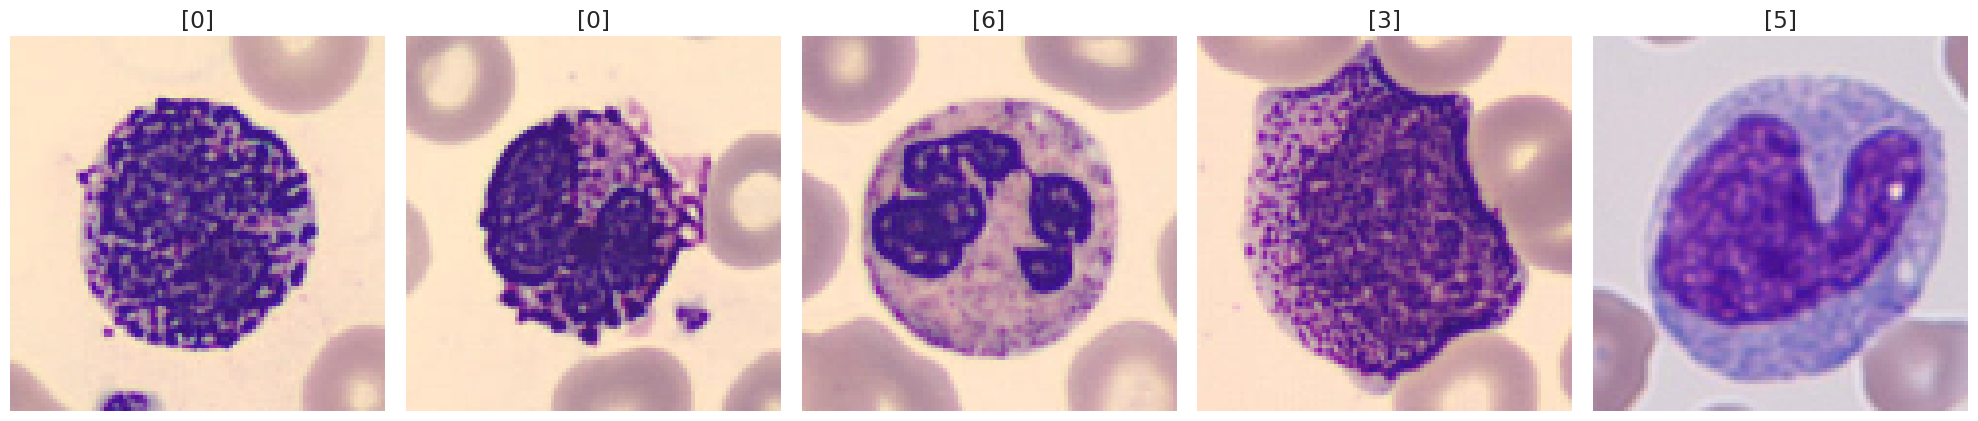

In [32]:
# Display a sample of images from the training-validation dataset
num_img = 5
random_indices = random.sample(range(len(X_train_val_test)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_train_val_test[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{y_train_val_test[idx]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [8]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val_test, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
6    2330
1    2179
3    2023
7    1643
2    1085
5     993
0     851
4     849
Name: count, dtype: int64


## 🔄 Process Data

In [9]:
# Split data into training and validation sets, maintaining class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(X_train_val_test, y_train_val_test, random_state=seed, test_size=0.1, stratify=y_train_val_test)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train_val.shape)
print("Training Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (10757, 96, 96, 3)
Training Label Shape: (10757, 1)
Test Data Shape: (1196, 96, 96, 3)
Test Label Shape: (1196, 1)


In [10]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (9681, 96, 96, 3)
Training Label Shape: (9681, 1)
Validation Data Shape: (1076, 96, 96, 3)
Validation Label Shape: (1076, 1)


In [11]:
# Normalize data to the range [0, 1]
X_train = (X_train / 255).astype('float32')
X_val = (X_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

In [12]:
# Compare categorical label and "default" label representation
# Display the categorical label
print('Categorical label:', y_train[0])
# Display the equivalent numeric label
print('"Default" label:', np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 0. 0. 0. 0. 1.]
"Default" label: 7


## 🧮 Define Network Parameters

In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
# Number of training epochs
epochs = 1000

# Batch size for training
batch_size = 256

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

#Kernel regularizer l2
l2_lambda=1e-3

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)
print("L2 Rate:", l2_lambda)

Epochs: 1000
Batch Size: 256
Learning Rate: 0.001
L2 Rate: 0.001


## 🛠️ Build the Model

In [ ]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    seed=seed,
    l2_lambda=l2_lambda

):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='conv1')(inputs)
    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='conv2')(x)
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dropout(0.5, name='dropout')(x)

    x = tfkl.Dense(units=output_shape, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='dense')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 96, 96, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 96, 96, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 48, 48, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 24, 24, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 36864)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 36864)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 8)                    │       294,920 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 8)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 314,312 (1.20 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

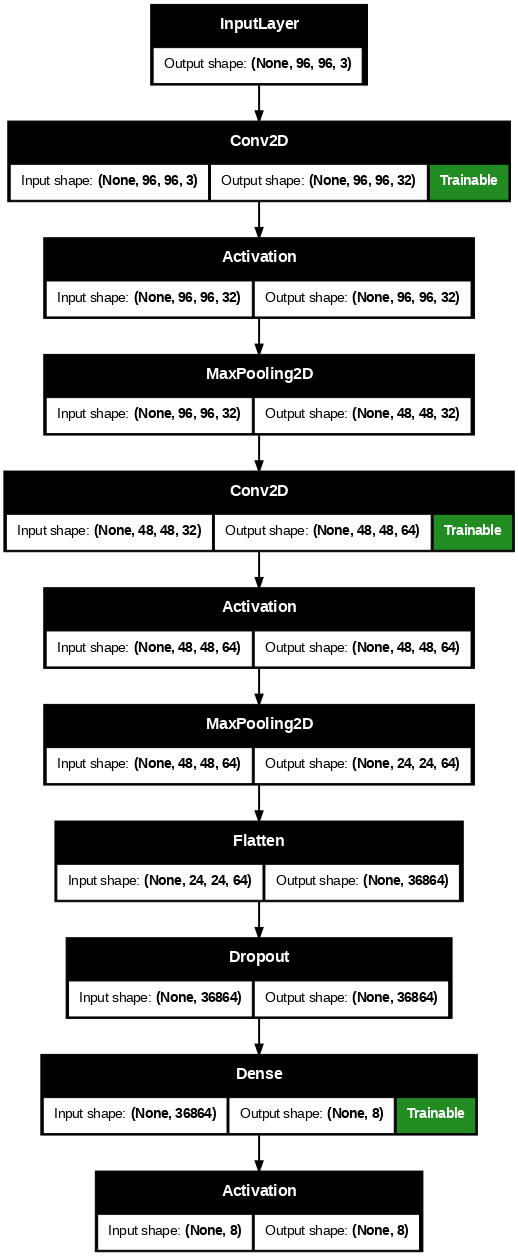

In [ ]:
# Build the model with specified input and output shapes
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🧠 Train the Model

In [ ]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'Baseline_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - accuracy: 0.3091 - loss: 1.9198 - val_accuracy: 0.6822 - val_loss: 1.0022
Epoch 2/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7242 - loss: 0.8811 - val_accuracy: 0.7584 - val_loss: 0.7557
Epoch 3/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8049 - loss: 0.6582 - val_accuracy: 0.7872 - val_loss: 0.6447
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8352 - loss: 0.5719 - val_accuracy: 0.8392 - val_loss: 0.5380
Epoch 5/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8579 - loss: 0.4975 - val_accuracy: 0.8606 - val_loss: 0.4865
Epoch 6/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8729 - loss: 0.4556 - val_accuracy: 0.8810 - val_loss: 0.4299
Epoch 7/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8969 - loss: 0.3997 - val_accuracy: 0.8941 - val_loss: 0.4042
Epoch 8/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9066 - loss: 0.3735 - val_ac

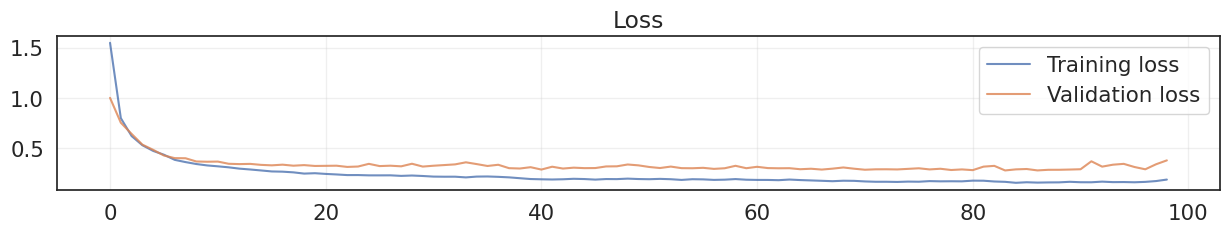

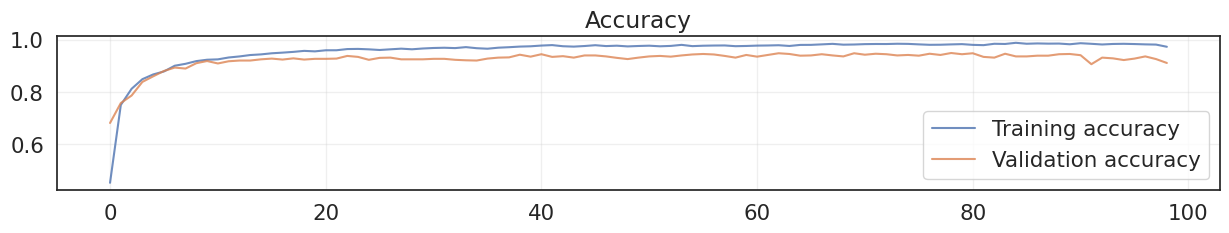

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## 🕹️ Use the Model - Make Inference

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 96, 96, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 96, 96, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 48, 48, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 24, 24, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 36864)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 36864)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 8)                    │       294,920 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 8)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 942,938 (3.60 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 628,626 (2.40 MB)

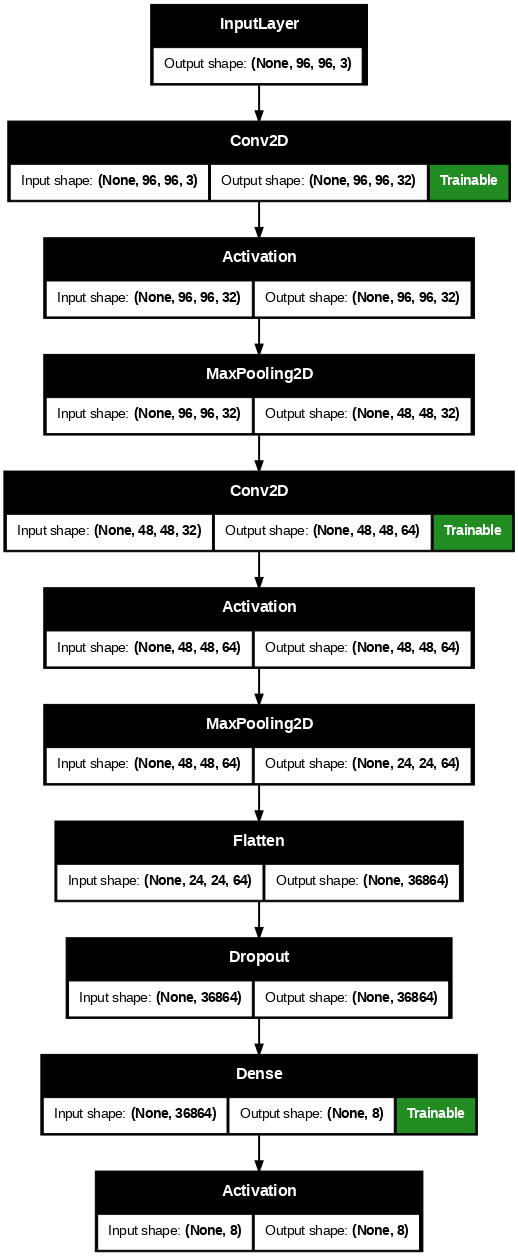

In [ ]:
# Load the saved model
model = tfk.models.load_model(model_filename)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Predictions Shape: (1196, 8)
Accuracy score over the test set: 0.9264
Precision score over the test set: 0.9308
Recall score over the test set: 0.9264
F1 score over the test set: 0.9266


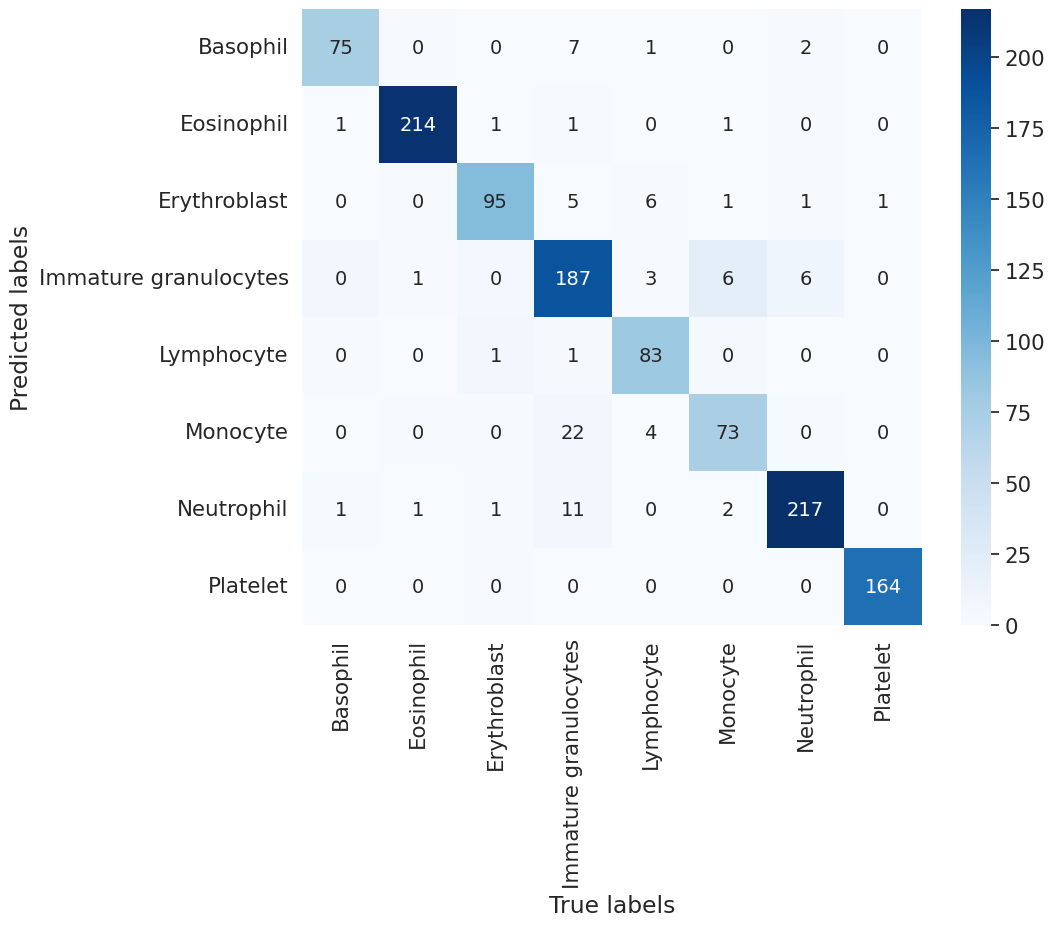

In [33]:
# Load the saved model
model_filename="Baseline_94.98.keras"
model = tfk.models.load_model(model_filename)

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Saliency  Maps visualization

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class SaliencyMapGenerator:
    def __init__(self, model, image_size=(96, 96), amplification_factor=5.0):
        """
        Initialize the saliency map generator.

        Args:
            model: TensorFlow model to analyze
            image_size: Tuple of (height, width) for input images
            amplification_factor: Float to scale the saliency map for better visibility
        """
        self.model = model
        self.image_size = image_size
        self.amplification_factor = amplification_factor

    def preprocess_image(self, image):
        """
        Preprocess a single image for the model.

        Args:
            image: Input image array

        Returns:
            Preprocessed tensor ready for model input
        """
        image = tf.convert_to_tensor(image)
        image = tf.image.resize(image, self.image_size)
        image = tf.cast(image, tf.float32) / 255.0
        return tf.expand_dims(image, axis=0)

    def compute_saliency_map(self, image, class_idx):
        """
        Compute saliency map for a given image and class index.

        Args:
            image: Input image array
            class_idx: Target class index

        Returns:
            Amplified and normalized saliency map array
        """
        processed_image = self.preprocess_image(image)

        with tf.GradientTape() as tape:
            tape.watch(processed_image)
            predictions = self.model(processed_image, training=False)
            class_score = predictions[:, class_idx]

        # Compute gradients
        grads = tape.gradient(class_score, processed_image)

        if grads is None:
            raise ValueError("Gradients could not be computed. Check model architecture and input.")

        # Take maximum across channels, normalize, and amplify
        saliency = tf.reduce_max(tf.abs(grads), axis=-1)
        saliency = saliency[0].numpy()

        # Normalize and amplify saliency map
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)
        saliency *= self.amplification_factor  # Amplify saliency for better visibility
        saliency = np.clip(saliency, 0, 1)  # Ensure values stay in [0, 1]
        return saliency

    def plot_saliency(self, image, class_idx, title=None, alpha=0.4):
        """
        Compute and plot saliency map overlaid on the original image.

        Args:
            image: Input image array
            class_idx: Target class index
            title: Optional title for the plot
            alpha: Transparency for saliency overlay
        """
        saliency = self.compute_saliency_map(image, class_idx)

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Plot original image
        ax1.imshow(np.clip(image, 0, 255).astype('uint8'))
        ax1.set_title('Original Image')
        ax1.axis('off')

        # Plot amplified saliency map
        im = ax2.imshow(saliency, cmap='hot')
        ax2.set_title(title or f'Saliency Map (Class {class_idx})')
        ax2.axis('off')

        # Add colorbar
        plt.colorbar(im, ax=ax2)
        plt.tight_layout()
        plt.show()

def visualize_class_saliency(model, X_test, y_test, num_images_per_class=5, amplification_factor=5.0, seed=42):
    """
    Visualize saliency maps for multiple images from each class.

    Args:
        model: TensorFlow model
        X_test: Test images
        y_test: Test labels
        num_images_per_class: Number of images to visualize per class
        amplification_factor: Float to scale the saliency map for better visibility
        seed: Random seed for reproducibility
    """
    np.random.seed(seed)
    generator = SaliencyMapGenerator(model, image_size=(96,96), amplification_factor=amplification_factor)

    # Get unique classes
    unique_classes = np.unique(y_test)

    for class_idx in unique_classes:
        print(f"\nGenerating saliency maps for class {class_idx}")

        # Get indices for current class
        class_indices = np.where(y_test == class_idx)[0]

        if len(class_indices) < num_images_per_class:
            print(f"Warning: Only {len(class_indices)} images available for class {class_idx}")
            selected_indices = class_indices
        else:
            selected_indices = np.random.choice(class_indices, num_images_per_class, replace=False)

        # Generate saliency maps
        for idx in selected_indices:
            image = X_test[idx]
            pred = model.predict(generator.preprocess_image(image*255), verbose=0)
            pred_class = np.argmax(pred)

            title = f"Class {class_idx} (Predicted: {pred_class})"
            generator.plot_saliency(image, pred_class, title=title)



def visualize_incorrect_predictions_saliency(model, X_test, y_test, amplification_factor=5.0, seed=42, max_images=10):
    """
    Visualize saliency maps for images that were incorrectly classified.

    Args:
        model: TensorFlow model
        X_test: Test images
        y_test: True test labels
        amplification_factor: Float to scale the saliency map for better visibility
        seed: Random seed for reproducibility
        max_images: Maximum number of incorrect predictions to visualize
    """
    np.random.seed(seed)
    generator = SaliencyMapGenerator(model, image_size=(96,96), amplification_factor=amplification_factor)

    incorrect_indices = []
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    # Find incorrect predictions
    for idx, (true_label, predicted_label) in enumerate(zip(y_test, predicted_classes)):
        if true_label != predicted_label:
            incorrect_indices.append(idx)

    print(f"Found {len(incorrect_indices)} incorrect predictions.")

    if len(incorrect_indices) == 0:
        print("No incorrect predictions to visualize.")
        return

    # Limit the number of images visualized
    if len(incorrect_indices) > max_images:
        incorrect_indices = np.random.choice(incorrect_indices, max_images, replace=False)

    # Generate saliency maps
    for idx in incorrect_indices:
        image = X_test[idx]
        true_label = y_test[idx]
        pred_class = predicted_classes[idx]

        title = f"True: {true_label}, Predicted: {pred_class}"
        generator.plot_saliency(image, pred_class, title=title)

In [ ]:
visualize_class_saliency(model, X_test*255, true_classes)

Output hidden; open in https://colab.research.google.com to view.

## Submission

In [24]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('Baseline_94.98.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [25]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py Baseline_94.98.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 55%)
  adding: Baseline_94.98.keras (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>